In [2]:
import sys
import numpy as np
from fluxlib import *
from scitbx import Yaml
from pathlib import Path
from sklearn.model_selection import train_test_split

In [3]:
cfg = Yaml("xgb_auxfill_malaysia_cfg.yaml").load()

drivers = cfg["drivers"]
timestamp_name = cfg["timestamp_name"]
timestamp_format = cfg["timestamp_format"]
data_path = cfg["source"]

In [4]:
filler = Filler()
loader = Loader(data_path)
df = loader.load_lowcost(drivers, timestamp_format).copy()

In [5]:
# train & test & apply
auxfiller = AuxFiller(df)
auxfiller()

In [31]:
import pickle

with open("aux_fill_model.pkl", "rb") as f:
    xgb_model = pickle.load(f)

In [32]:
import pandas as pd
reverse_date = 10
reverse_length = np.int(reverse_date * 48)
df_ori = df
df = df.interpolate(method = "linear", limit = 2)
maxv = df.max().values[0]
minv = df.min().values[0]

gap_idxs = np.where(np.isfinite(df.values.ravel()) == False)[0]
for idx in gap_idxs:
    # print(idx)
    if idx < reverse_length:
        X = df.iloc[0: idx, :].values.ravel()
        reps = np.ceil(reverse_length / idx).astype(np.int)
        X = np.tile(X, reps)[0: reverse_length].reshape(1, -1)
    else:
        X = df.iloc[idx - reverse_length: idx, :].values.reshape(1, -1)
    pred_val = xgb_model.predict(X)[0]
    # print(df.iloc[idx, :])
    if (pred_val > maxv) or (pred_val < minv):
        if idx == len(df) - 1:
            pred_val = df.interpolate().values[-1, 0]
        else:
            pred_val = df.iloc[0: idx + 1, :].interpolate().values[-1, 0]
    df.iloc[idx, :] = pred_val
#     print(pred_val, df.iloc[idx - 1, :].values[0])
    
#     break

# print(df)

In [83]:
df1 = df

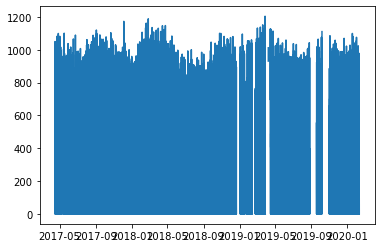

In [34]:
from matplotlib import pyplot as plt
# plt.plot(df.index, df)
plt.plot(df_ori.index, df_ori)